# Gaussian Mixture Model

In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [8]:
from pixyz.distributions import Normal, Categorical, Bernoulli
from pixyz.distributions.mixture_distributions import MixtureModel

z_dim = 3 # the number of mixture
x_dim = 2

distributions = []
for i in range(z_dim):
    loc = torch.randn(x_dim)
    scale = torch.empty(x_dim).fill_(1.)
    distributions.append(Normal(loc=loc, scale=scale, var=["x"], name="p_%d" %i))

probs = torch.empty(z_dim).fill_(1. / z_dim)
prior = Categorical(probs=probs, var=["z"], name="prior")

p = MixtureModel(distributions=distributions, prior=prior)

In [5]:
print(p)

Distribution:
  p(x,z) = p_0(x|z=0)prior(z=0) + p_1(x|z=1)prior(z=1) + p_2(x|z=2)prior(z=2)
Network architecture:
  MixtureModel(
    (_distributions): ModuleList(
      (0): Normal()
      (1): Normal()
      (2): Normal()
    )
    (_prior): Categorical()
  )


In [6]:
p.sample(batch_size=10)

{'x': tensor([[[-1.2168,  0.2296],
          [ 0.1656,  0.9038]],
 
         [[-3.0954,  0.2584],
          [ 2.0642, -1.4496]],
 
         [[ 0.4877, -1.4088],
          [-0.5468,  0.4463]],
 
         [[-0.4815, -1.0463],
          [-1.8004,  0.4840]],
 
         [[ 1.3897, -1.2663],
          [ 0.2197,  2.1592]],
 
         [[-2.3257,  0.6183],
          [-1.2371,  1.0715]],
 
         [[-1.9873, -0.2112],
          [-1.4316,  1.1953]],
 
         [[-2.0753,  1.0172],
          [-1.9196, -0.2754]],
 
         [[-0.1497, -1.9550],
          [-1.4309,  1.1650]],
 
         [[-0.6503, -0.8455],
          [-3.5943, -1.9934]]]), 'z': tensor([[0., 0., 1.],
         [1., 0., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.]])}

### toy dataset

In [25]:
# https://angusturner.github.io/generative_models/2017/11/03/pytorch-gaussian-mixture-model.html

def sample(mu, var, nb_samples=500):
    """
    Return a tensor of (nb_samples, features), sampled
    from the parameterized gaussian.
    :param mu: torch.Tensor of the means
    :param var: torch.Tensor of variances (NOTE: zero covars.)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt())
        ]
    return torch.stack(out, dim=0)

In [26]:
# generate some clusters
cluster1 = sample(
    torch.Tensor([2.5, 2.5]),
    torch.Tensor([1.2, .8]),
    nb_samples=500
)

cluster2 = sample(
    torch.Tensor([7.5, 7.5]),
    torch.Tensor([.75, .5]),
    nb_samples=500
)

cluster3 = sample(
    torch.Tensor([8, 1.5]),
    torch.Tensor([.6, .8]),
    nb_samples=1000
)

In [27]:
def plot_2d_sample(sample):
    sample_np = sample.numpy()
    x = sample_np[:, 0]
    y = sample_np[:, 1]
    plt.scatter(x, y)

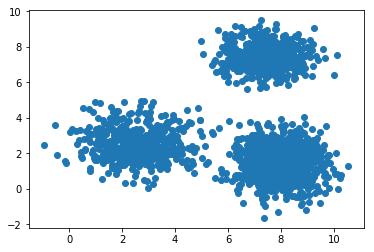

In [28]:
# create the dummy dataset, by combining the clusters.
X = torch.cat([cluster1, cluster2, cluster3])
plot_2d_sample(X)

In [29]:
sample = {"x": X}

In [30]:
p.get_posterior_probs(sample)

tensor([[9.9313e-01, 9.8460e-01, 1.2533e-02,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [6.7581e-04, 7.4875e-03, 9.6026e-01,  ..., 7.4565e-09, 2.9357e-09,
         2.3085e-11],
        [6.1947e-03, 7.9177e-03, 2.7211e-02,  ..., 1.7864e-07, 2.2593e-08,
         2.2293e-08]])